# Ocean Carrier Alliances Project - Analysis and Modeling

The initial model for the project inspects the effects of carrier alliances on frequency of service. We estimate this using the following equation:

$$ S_{lct} = b X_{lct} + a_1 AM_{ct}PC_{lc} + a_2 AM_{ct} + a_3 PC_{lc} + \epsilon_{lct} $$

where:
- $l$ is the lane, i.e. the departure port and arrival port pair
- $c$ is the carrier
- $t$ is the time period, which we aggregate to months (e.g., May 2019)
- $S$ is the frequency of service, i.e. the number of voyages provided to that lane by the carrier in the given month. 
- $X$ are the correction variables
- $AM$ is an indicator of whether or not the carrier is part of an alliance
- $PC$ is an indicator of whether or not the lane was serviced by that carrier before the alliance took effect. 

Since our initial interest is the impact of alliances on domestic producers, we start by analysing the exports database. 

## Data Import and Transformation

The data come from the PIERS database and are primarily processed in the [PIERS Data Project](https://github.com/epistemetrica/PIERS-Data-Project) with specific preparations for this analysis occuring in the 'oca_data_pred.ipynb' file in this repository. 

In [54]:
#preliminaries 
import pandas as pd #v2.1.3
import numpy as np
import polars as pl #v0.20.18
import plotly_express as px #v0.4.1 
import datetime as dt
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

#enable string cache for polars categoricals
pl.enable_string_cache()

#load data to lazyframe
exports_lf = pl.scan_parquet('data/exports/exports.parquet')
#ignore unused columns 
exports_lf = (
    exports_lf.select(
        'teus',
        #'carrier_name',
        #'carrier_scac',
        #'vessel_name',
        #'voyage_number',
        'vessel_id',
        'departure_port_code',
        'departure_port_name',
        #'coast_region', #note coast region was restricted to west coast in the data_prep nb
        'hs_code',
        #'date',
        #'dest_territory',
        #'dest_region',
        'arrival_port_code',
        'arrival_port_name',
        #'direction',
        'bol_id',
        'year',
        'month',
        'lane_id',
        'lane_name',
        'unified_carrier_name',
        'unified_carrier_scac',
        'vessel_lane_pair',
        'date_departure'
    )
)

In [55]:
#collect data into regular dataframe for analysis
df = (
    exports_lf
    #aggregate by lane, carrier, and month, counting unique departure dates to determine service frequency
    .group_by('lane_id', 'unified_carrier_scac', 'year', 'month')
    .agg(pl.col('date_departure').unique().count().alias('service_freq'))
    #rename carrier code column
    .rename({'unified_carrier_scac':'scac'})
    #cast data types
    .cast({'service_freq':pl.Int16})
    .with_columns(pl.col('month').str.to_datetime('%Y%m'))
    .collect()
)

#display
display(df.describe())
df.head()

statistic,lane_id,scac,year,month,service_freq
str,str,str,f64,str,f64
"""count""","""710650""","""710650""",710650.0,"""710650""",710650.0
"""null_count""","""0""","""0""",0.0,"""0""",0.0
"""mean""",null,null,2015.350219,"""2015-10-22 17:…",2.678755
"""std""",null,null,4.94651,null,1.940277
"""min""",null,null,2005.0,"""2005-01-01 00:…",1.0
"""25%""",null,null,2011.0,"""2011-12-01 00:…",1.0
"""50%""",null,null,2016.0,"""2016-06-01 00:…",2.0
"""75%""",null,null,2019.0,"""2019-12-01 00:…",4.0
"""max""",null,null,2023.0,"""2023-11-01 00:…",25.0


lane_id,scac,year,month,service_freq
cat,cat,i32,datetime[μs],i16
"""2709_57035""","""ONEY""",2023,2023-02-01 00:00:00,4
"""3001_53551""","""MSCU""",2020,2020-08-01 00:00:00,5
"""2709_54600""","""MLSL""",2021,2021-03-01 00:00:00,1
"""2713_76283""","""MLSL""",2017,2017-07-01 00:00:00,1
"""3001_50500""","""MSCU""",2020,2020-05-01 00:00:00,1


### Alliance Membership

Data on which carriers are part of which alliances was collected, where available, from alliance agreements filed with the Federal Maritime Commission. Where primary sources were not available, alliance membership was determined from industry reports and various media sources. 

In [56]:
#load alliance membership data from csv
alliances_df = pl.read_csv('data/misc/alliance_memberships.csv', dtypes={'scac':pl.Categorical, 'year':pl.Int32}).drop('carrier')
alliances_df.head()

scac,year,2m,ocean,the
cat,i32,i64,i64,i64
"""MLSL""",2023,1,0,0
"""MLSL""",2022,1,0,0
"""MLSL""",2021,1,0,0
"""MLSL""",2020,1,0,0
"""MLSL""",2019,1,0,0


Since we are initially concerned with analysis based on whether or not a carrier was a member of an alliance, we unify the above into a single boolean column.

In [57]:
alliances_df = (
    alliances_df.with_columns(
        #set new 'alliance_member' column to 1 if the carrier is a member of any alliance
        pl.when((pl.col('2m') + pl.col('ocean') + pl.col('the'))>0)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias('alliance_member')
    )
    #drop individual alliance columns
    .drop('2m', 'ocean', 'the')
)

#join alliance membership data into main df
df = (
    df.join(alliances_df, on=['scac', 'year'], how='left')
    #set missing alliance membership values to null 
    .with_columns(pl.col('alliance_member').fill_null(0))
)

In [58]:
df.head()

lane_id,scac,year,month,service_freq,alliance_member
cat,cat,i32,datetime[μs],i16,i32
"""2709_57035""","""ONEY""",2023,2023-02-01 00:00:00,4,0
"""3001_53551""","""MSCU""",2020,2020-08-01 00:00:00,5,1
"""2709_54600""","""MLSL""",2021,2021-03-01 00:00:00,1,1
"""2713_76283""","""MLSL""",2017,2017-07-01 00:00:00,1,1
"""3001_50500""","""MSCU""",2020,2020-05-01 00:00:00,1,1


### Identifying whether a lane was serviced by that carrier before the alliance took effect

In [59]:
df= (
    #get total voyages prior to joining an alliance for each lane and carrier
    df.with_columns(
        pl.when(pl.col('alliance_member')==0)
        .then(pl.col('service_freq').sum().over('lane_id', 'scac'))
        .otherwise(pl.lit(0))
        .alias('service_prior')
    )
    #simplify to 1 if any service prior to alliance, 0 otherwise
    .with_columns(
        pl.when(pl.col('service_prior').sum()>0)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .over('lane_id', 'scac')
        .alias('service_prior')
    )
)
df.head()

lane_id,scac,year,month,service_freq,alliance_member,service_prior
cat,cat,i32,datetime[μs],i16,i32,i32
"""2709_57035""","""ONEY""",2023,2023-02-01 00:00:00,4,0,1
"""3001_53551""","""MSCU""",2020,2020-08-01 00:00:00,5,1,1
"""2709_54600""","""MLSL""",2021,2021-03-01 00:00:00,1,1,0
"""2713_76283""","""MLSL""",2017,2017-07-01 00:00:00,1,1,0
"""3001_50500""","""MSCU""",2020,2020-05-01 00:00:00,1,1,1


## Simple OLS Regression

Leaving out any correction variables for the moment, we estimate a simple OLS regression model on the equation above. 

In [60]:
#set dependent and independent variables
Y = df.select('service_freq').to_pandas()
X = (
    df.select('alliance_member', 'service_prior')
    .with_columns((pl.col('alliance_member')*pl.col('service_prior')).alias('alliance*prior'))
    .to_pandas()
)
#add intercept
X = sm.add_constant(X)
#instantiate model
model = sm.OLS(Y,X)
#run regression
results = model.fit()

#display
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           service_freq   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2377.
Date:                Fri, 19 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:23   Log-Likelihood:            -1.4759e+06
No. Observations:              710650   AIC:                         2.952e+06
Df Residuals:                  710646   BIC:                         2.952e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             2.16e+08   1.33e+09      0.162      0.871   -2.39e+09    2.82e+09
alliance_member  -2.16e+08   1.33e+09     -0.162      0.871   -2.82e+09    2.39e+09
service_prior    -2.16e+08   1.33e+09     -0.162      0.871   -2.82e+09    2.39e+09
alliance*prior    2.16e+08   1.33e+09      0.162      0.871   -2.39e+09    2.82e+09
==============================================================================
Omnibus:                   253425.653   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1050075.348
Skew:                           1.739   Prob(JB):                         0.00
Kurtosis:                       7.834   Cond. No.                     1.64e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.26e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

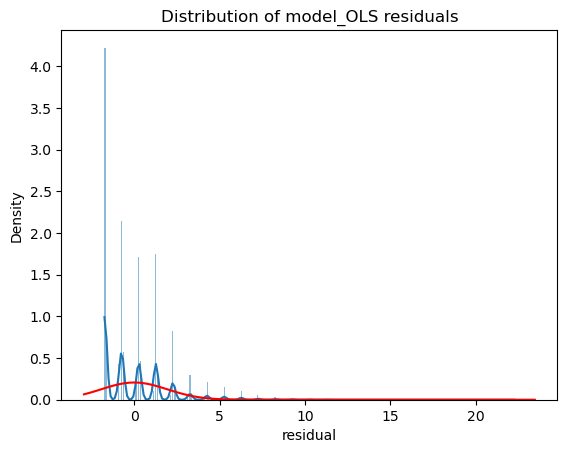

In [61]:
#obtain moments for residuals
mu, std = scipy.stats.norm.fit(results.resid)

#plot resid distribution
fig, ax = plt.subplots()
sns.histplot(x=results.resid, ax=ax, stat='density', linewidth=0, kde=True)
ax.set(title='Distribution of model_OLS residuals', xlabel='residual')

#add corresponding normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x,mu,std)
sns.lineplot(x=x, y=p, color='red', ax=ax)
plt.show()

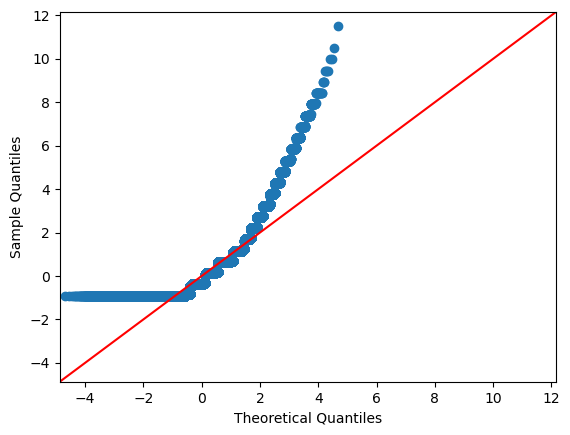

In [63]:
sm.qqplot(results.resid, line='45', fit=True);

### Limitations

The simplistic method of identifying when a carrier had previously serviced that lane results in the alliance*prior interaction term being uniformly zero. We need to decide on a better means of identification. 